In [1]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
import numpy as np
%matplotlib inline

### Sbox

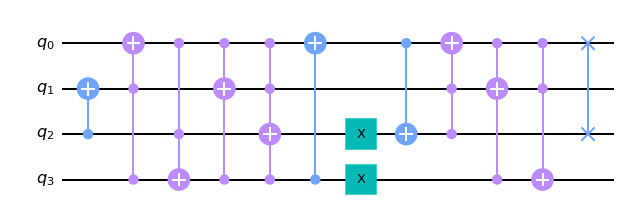

In [33]:
sbox = QuantumCircuit(4)
qubits = [
    [2,1],
    [3,1,0],
    [0,2,3],
    [0,3,1],
    [0,1,3,2],
    [3,0],
    [2],
    [3],
    [0,2],
    [1,2,0],
    [0,3,1],
    [0,1,3]
]

for i in qubits:
    if len(i) == 1:
        sbox.x(i[0])
    elif len(i) == 2:
        sbox.cnot(i[0],i[1])
    elif len(i) == 3:
        sbox.toffoli(i[0],i[1],i[2])
    else:
        sbox.mct(i[:-1],i[-1])

sbox.swap(0,2)

sbox.draw('mpl')

In [39]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')

for i in range(16):
    
    num = bin(i)[2:][::-1]
    qc = QuantumCircuit(4)
    
    for index, j in enumerate(num):
        if j == '1':
            qc.x(3 - index)
            
    qc = qc.compose(sbox,range(4))
    qc.measure_all()
    
    res = execute(qc,backend=simulator, shots=shots).result()
    counts = res.get_counts(qc)
    s = list(list(counts.keys())[0])
    
    out = int("".join(s),2)
    print(i, out)
    
    del qc

0 9
1 4
2 10
3 11
4 13
5 1
6 8
7 5
8 6
9 2
10 0
11 3
12 12
13 14
14 15
15 7


In [38]:
sbox_gate = sbox.to_gate()
sbox_gate.name = 'SN'

### MC

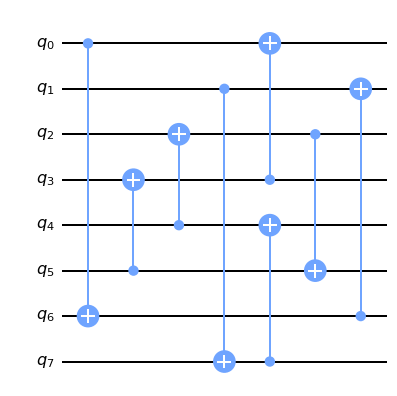

In [40]:
mc = QuantumCircuit(8)
qubits = [
    [0,6],
    [5,3],
    [4,2],
    [1,7],
    [7,4],
    [2,5],
    [3,0],
    [6,1]
]

for i in qubits:
    mc.cnot(i[0],i[1])

mc.draw('mpl')

In [45]:
mix_col = np.array([[1, 4], [4, 1]])
def galoisMult(b, a):
    p = 0
    hiBitSet = 0
    for i in range(4):
        if b & 1 == 1:
            p ^= a
        a <<= 1
        hiBitSet = a & 0x10
        if hiBitSet:
            a ^= 0x13
        b >>= 1
    return p

def mix_column(state):
    res = np.zeros((2, 2)).astype(int)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                res[i][j] ^= galoisMult(mix_col[i][k],state[k][j])
    return res

In [90]:
state = np.zeros((2,2)).astype(int)
count = 0
test = [0]*8
for i in range(16):
    state[0][0] = i
    for j in range(16):
        state[1][0] = j
        mc_state = mix_column(state)
        actual = ((mc_state[0][0] << 12) | (mc_state[1][0] << 8) | (mc_state[0][1] << 4) | mc_state[1][1])
        
        qc = QuantumCircuit(8)
        
        num = ((state[0][0] << 12) | (state[1][0] << 8) | (state[0][1] << 4) | state[1][1])
        num = bin(num)[2:][::-1]
        for index,k in enumerate(num):
            if k == '1':
                qc.x(7-index)
            
        qc = qc.compose(mc, range(8))
        qc.measure_all()
        
        res = execute(qc,backend=simulator, shots=shots).result()
        counts = res.get_counts(qc)
        s = list(counts.keys())[0] 
        s1 = s[:4]
        s2 = s[4:]
        real = bin(mc_state[0][0])[2:].zfill(4)+ bin(mc_state[1][0])[2:].zfill(4)
        print(real)
        print(s)
        print()
        s = list(s)
        s[0], s[1] = s[1], s[0]
        s[1], s[3] = s[3], s[1]
        s[3], s[4] = s[4], s[3]
        s[4], s[5] = s[5], s[4]
        s[5], s[7] = s[7], s[5]
        s = "".join(s)
        
        for i in range(8):
            test[i] += int(real[i])^int(s[i])
    
        out = list(counts.keys())[0][::-1] + '00000000'
        out = int(out, 2)
        
#         print(actual,out)
        if actual == out:
            count+=1
        del qc

if count == 16*16:
    print("Verified")

test

00000000
00000000

01000001
10010000

10000010
01000010

11000011
11010010

00110100
00101001

01110101
10111001

10110110
01101011

11110111
11111011

01101000
00110100

00101001
10100100

11101010
01110110

10101011
11100110

01011100
00011101

00011101
10001101

11011110
01011111

10011111
11001111

00010100
00001001

01010101
10011001

10010110
01001011

11010111
11011011

00100000
00100000

01100001
10110000

10100010
01100010

11100011
11110010

01111100
00111101

00111101
10101101

11111110
01111111

10111111
11101111

01001000
00010100

00001001
10000100

11001010
01010110

10001011
11000110

00101000
00100100

01101001
10110100

10101010
01100110

11101011
11110110

00011100
00001101

01011101
10011101

10011110
01001111

11011111
11011111

01000000
00010000

00000001
10000000

11000010
01010010

10000011
11000010

01110100
00111001

00110101
10101001

11110110
01111011

10110111
11101011

00111100
00101101

01111101
10111101

10111110
01101111

11111111
11111111

00001000
000

[0, 0, 0, 0, 0, 0, 0, 0]